In [1]:
!pip install split-folders

### **Importing of Necessary Libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import wandb
from wandb.keras import WandbCallback
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(60%), Validation set(20%), and Test set(20%).

In [4]:
base_ds = '/kaggle/input/rosenet/Original Dataset'
base_ds = pathlib.Path(base_ds)

In [5]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.6,.2,.2), group_prefix=None)

Copying files: 917 files [00:12, 72.96 files/s]


In [6]:
Blackspot= [fn for fn in os.listdir(f'{base_ds}/Black Spot') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
DownyMildew= [fn for fn in os.listdir(f'{base_ds}/Downy Mildew') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
FreshLeaf= [fn for fn in os.listdir(f'{base_ds}/Fresh Leaf') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Die_Back= [fn for fn in os.listdir(f'{base_ds}/Die Back') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Gall_Midge= [fn for fn in os.listdir(f'{base_ds}/Gall Midge') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Healthy= [fn for fn in os.listdir(f'{base_ds}/Healthy') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Powdery_Mildew= [fn for fn in os.listdir(f'{base_ds}/Powdery Mildew') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]
#Sooty_Mould= [fn for fn in os.listdir(f'{base_ds}/Sooty Mould') if (fn.endswith('.jpg') or fn.endswith('.jpeg'))]


coffee= [Blackspot, DownyMildew, FreshLeaf]
coffee_classes = []
for i in os.listdir('imgs/train'):
    coffee_classes+=[i]
coffee_classes.sort()



### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

Total images: 917
Total number of classes: 3
Total Black Spot images: 313
Total Downy Mildew images: 200
Total Fresh Leaf images: 404


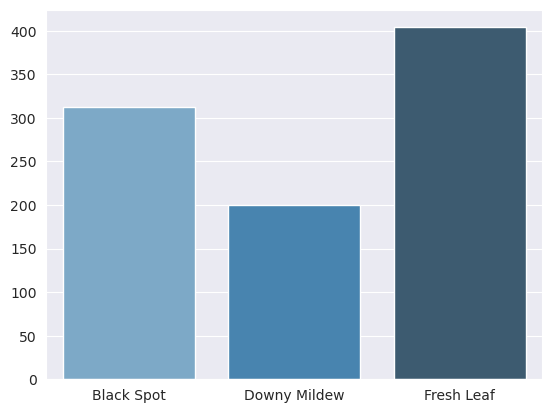

In [7]:
image_count1= len(list(base_ds.glob('*/*.jpg')))
image_count2 = len(list(base_ds.glob('*/*.jpeg')))
image_count=image_count1+image_count2
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')
count = 0
coffee_count = []
for x in coffee_classes:
  print(f'Total {x} images: {len(coffee[count])}')
  coffee_count.append(len(coffee[count]))
  count+=1

sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (1396, 1109, 3)


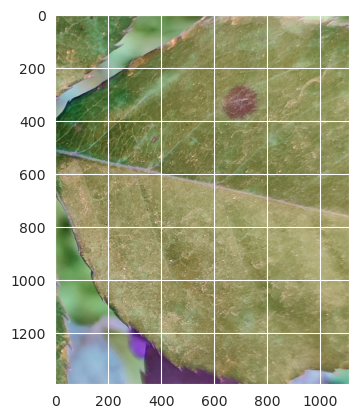

In [8]:
sample_img = cv2.imread('/kaggle/input/rosenet/Original Dataset/Black Spot/Black Spot (1).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [9]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in coffee_classes:
    i+=1
    plt.subplot(1,8, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

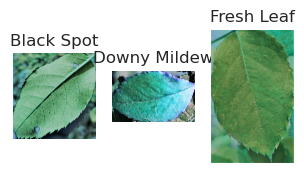

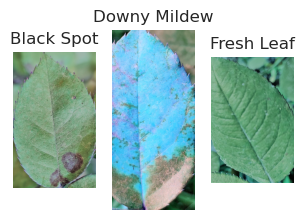

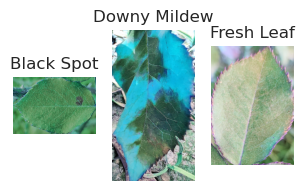

In [10]:
for i in range(3):
  load_random_img(base_ds,coffee_classes)

In [11]:
batch_size =16
img_height, img_width =128,128
input_shape = (img_height, img_width, 3)

CONFIG=dict(
            batch_size =16,
            img_height=128,
            img_width =128,
            )

### **Data Pre-processing**

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                               rotation_range=30,
                               zoom_range=0.15,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.15,
                               horizontal_flip=True,
                               fill_mode="nearest")

test_datagen=ImageDataGenerator(rescale=1./255)

In [13]:
train_ds = train_datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical',
    shuffle=True
    )

val_ds = train_datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = test_datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 549 images belonging to 3 classes.
Found 182 images belonging to 3 classes.
Found 186 images belonging to 3 classes.


In [14]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

CONFIG['model_name'] = 'MobileNetV2'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose',
                 entity="sanjeevsharma22",
                 config=CONFIG,
                 group='MobileNetV2', 
                 job_type='train')

wandb.config.type = 'baseline'

In [15]:
CONFIG['model_name'] = 'MobileNetV2'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose',
                 entity="sanjeevsharma22",
                 config=CONFIG,
                 group='MobileNetV2', 
                 job_type='train')

wandb.config.type = 'baseline'

wandb: Currently logged in as: sanjeevsharma22. Use `wandb login --relogin` to force relogin


Training configuration:  {'batch_size': 16, 'img_height': 128, 'img_width': 128, 'model_name': 'MobileNetV2'}


wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230606_041738-4w2zs47r
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run hopeful-pine-4
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/4w2zs47r


## **Transfer Learning**

In [16]:
model=tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model= tf.keras.Model(inputs, x)

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 3,572,803
Trainable params: 3,538,691
Non-train

## **Fine Tuning**

In [18]:
history3 =model.fit(train_ds, epochs =30, validation_data = val_ds,callbacks=[WandbCallback()])
run.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 0.9151 - accuracy: 0.5464

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.2s


35/35 [==============================] - 53s 1s/step - loss: 0.9151 - accuracy: 0.5464 - val_loss: 0.6372 - val_accuracy: 0.7473
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.8251

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.1s


35/35 [==============================] - 41s 1s/step - loss: 0.5012 - accuracy: 0.8251 - val_loss: 0.5309 - val_accuracy: 0.7802
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8397

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.1s


35/35 [==============================] - 41s 1s/step - loss: 0.3901 - accuracy: 0.8397 - val_loss: 0.3703 - val_accuracy: 0.8736
Epoch 4/30
35/35 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.9071

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.2s


35/35 [==============================] - 43s 1s/step - loss: 0.2714 - accuracy: 0.9071 - val_loss: 0.2530 - val_accuracy: 0.9066
Epoch 5/30
35/35 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9071

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.2s


35/35 [==============================] - 41s 1s/step - loss: 0.2462 - accuracy: 0.9071 - val_loss: 0.2308 - val_accuracy: 0.9176
Epoch 6/30
35/35 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9180

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.2s


35/35 [==============================] - 41s 1s/step - loss: 0.2028 - accuracy: 0.9180 - val_loss: 0.1915 - val_accuracy: 0.9231
Epoch 7/30
35/35 [==============================] - 17s 476ms/step - loss: 0.1966 - accuracy: 0.9344 - val_loss: 0.2106 - val_accuracy: 0.9451
Epoch 8/30
35/35 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9399

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.2s


35/35 [==============================] - 42s 1s/step - loss: 0.1478 - accuracy: 0.9399 - val_loss: 0.1677 - val_accuracy: 0.9451
Epoch 9/30
35/35 [==============================] - 17s 465ms/step - loss: 0.1432 - accuracy: 0.9417 - val_loss: 0.2071 - val_accuracy: 0.9231
Epoch 10/30
35/35 [==============================] - 17s 473ms/step - loss: 0.1212 - accuracy: 0.9581 - val_loss: 0.1697 - val_accuracy: 0.9560
Epoch 11/30
35/35 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9563

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.2s


35/35 [==============================] - 40s 1s/step - loss: 0.1222 - accuracy: 0.9563 - val_loss: 0.1347 - val_accuracy: 0.9505
Epoch 12/30
35/35 [==============================] - 17s 476ms/step - loss: 0.0970 - accuracy: 0.9690 - val_loss: 0.1631 - val_accuracy: 0.9505
Epoch 13/30
35/35 [==============================] - 17s 468ms/step - loss: 0.1113 - accuracy: 0.9581 - val_loss: 0.2404 - val_accuracy: 0.9121
Epoch 14/30
35/35 [==============================] - 17s 467ms/step - loss: 0.0799 - accuracy: 0.9690 - val_loss: 0.1572 - val_accuracy: 0.9615
Epoch 15/30
35/35 [==============================] - 17s 471ms/step - loss: 0.0878 - accuracy: 0.9654 - val_loss: 0.1899 - val_accuracy: 0.9396
Epoch 16/30
35/35 [==============================] - 17s 468ms/step - loss: 0.1150 - accuracy: 0.9617 - val_loss: 0.1549 - val_accuracy: 0.9286
Epoch 17/30
35/35 [==============================] - 17s 472ms/step - loss: 0.0763 - accuracy: 0.9781 - val_loss: 0.1461 - val_accuracy: 0.9560
Epoch 1

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.2s


35/35 [==============================] - 42s 1s/step - loss: 0.0492 - accuracy: 0.9818 - val_loss: 0.0844 - val_accuracy: 0.9725
Epoch 20/30
35/35 [==============================] - 17s 471ms/step - loss: 0.0617 - accuracy: 0.9818 - val_loss: 0.1022 - val_accuracy: 0.9725
Epoch 21/30
35/35 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9854

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.2s


35/35 [==============================] - 40s 1s/step - loss: 0.0530 - accuracy: 0.9854 - val_loss: 0.0726 - val_accuracy: 0.9780
Epoch 22/30
35/35 [==============================] - 17s 473ms/step - loss: 0.0593 - accuracy: 0.9727 - val_loss: 0.1154 - val_accuracy: 0.9615
Epoch 23/30
35/35 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9818

wandb: Adding directory to artifact (/kaggle/working/wandb/run-20230606_041738-4w2zs47r/files/model-best)... Done. 0.2s


35/35 [==============================] - 40s 1s/step - loss: 0.0618 - accuracy: 0.9818 - val_loss: 0.0666 - val_accuracy: 0.9835
Epoch 24/30
35/35 [==============================] - 17s 472ms/step - loss: 0.0568 - accuracy: 0.9818 - val_loss: 0.1190 - val_accuracy: 0.9670
Epoch 25/30
35/35 [==============================] - 17s 472ms/step - loss: 0.0503 - accuracy: 0.9745 - val_loss: 0.1079 - val_accuracy: 0.9560
Epoch 26/30
35/35 [==============================] - 19s 532ms/step - loss: 0.0828 - accuracy: 0.9709 - val_loss: 0.0920 - val_accuracy: 0.9670
Epoch 27/30
35/35 [==============================] - 17s 475ms/step - loss: 0.0472 - accuracy: 0.9836 - val_loss: 0.1519 - val_accuracy: 0.9505
Epoch 28/30
35/35 [==============================] - 17s 474ms/step - loss: 0.0318 - accuracy: 0.9909 - val_loss: 0.0825 - val_accuracy: 0.9725
Epoch 29/30
35/35 [==============================] - 17s 472ms/step - loss: 0.0265 - accuracy: 0.9909 - val_loss: 0.1327 - val_accuracy: 0.9725
Epoch 3

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:     accuracy ▁▅▆▇▇▇▇▇▇▇▇█▇█████████████████
wandb:        epoch ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
wandb:         loss █▅▄▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: val_accuracy ▁▂▅▆▆▆▇▇▆▇▇▇▆▇▇▆▇▇███▇██▇█▇███
wandb:     val_loss █▇▅▃▃▃▃▂▃▂▂▂▃▂▃▂▂▂▁▁▁▂▁▂▂▁▂▁▂▁
wandb: 
wandb: Run summary:
wandb:      accuracy 0.98543
wandb:    best_epoch 22
wandb: best_val_loss 0.06657
wandb:         epoch 29
wandb:          loss 0.04194
wandb:  val_accuracy 0.96703
wandb:      val_loss 0.10145
wandb: 
wandb: 🚀 View run hopeful-pine-4 at: https://wandb.ai/sanjeevsharma22/Rose/runs/4w2zs47r
wandb: Synced 6 W&B file(s), 1 media file(s), 55 artifact file(s) and 1 other file(s)
wandb: Find logs at: ./wandb/run-20230606_041738-4w2zs47r/logs


## **Final Evaluation**

In [19]:
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose', 
                 config=CONFIG,
                 group='MobileNetV2', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

# Finish the run
run.finish()

wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230606_043440-mgpkgp69
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run genial-shadow-6
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/mgpkgp69


12/12 [==============================] - 3s 213ms/step - loss: 0.0442 - accuracy: 0.9785


wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run genial-shadow-6 at: https://wandb.ai/sanjeevsharma22/Rose/runs/mgpkgp69
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230606_043440-mgpkgp69/logs


In [20]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 0.04421371594071388,"
" Accuracy: 97.8494644165039


In [21]:
Y_pred =model.predict(test_ds)

12/12 [==============================] - 5s 213ms/step


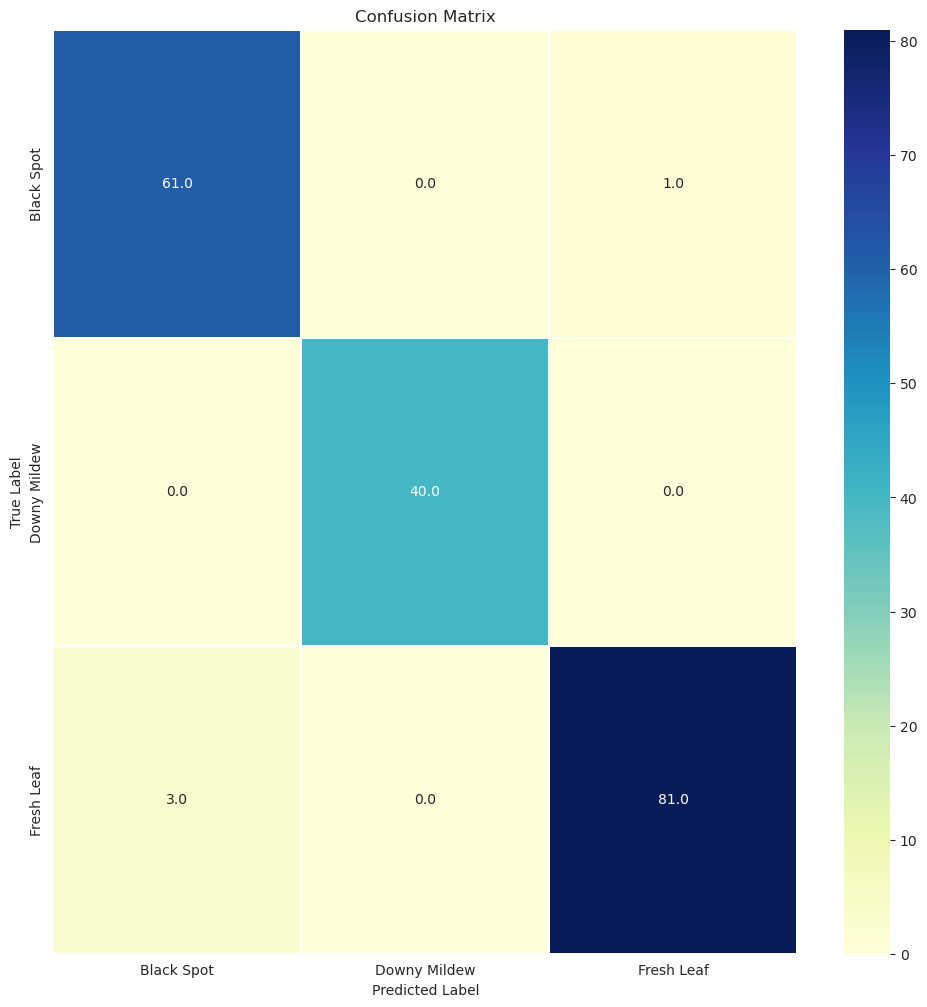

In [22]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [23]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

,precision,recall,f1-score,support
Black Spot,0.983871,0.953125,0.968254,64.000000
Downy Mildew,1.000000,1.000000,1.000000,40.000000
Fresh Leaf,0.964286,0.987805,0.975904,82.000000
accuracy,0.978495,0.978495,0.978495,0.978495
macro avg,0.982719,0.980310,0.981386,186.000000
weighted avg,0.978705,0.978495,0.978453,186.000000


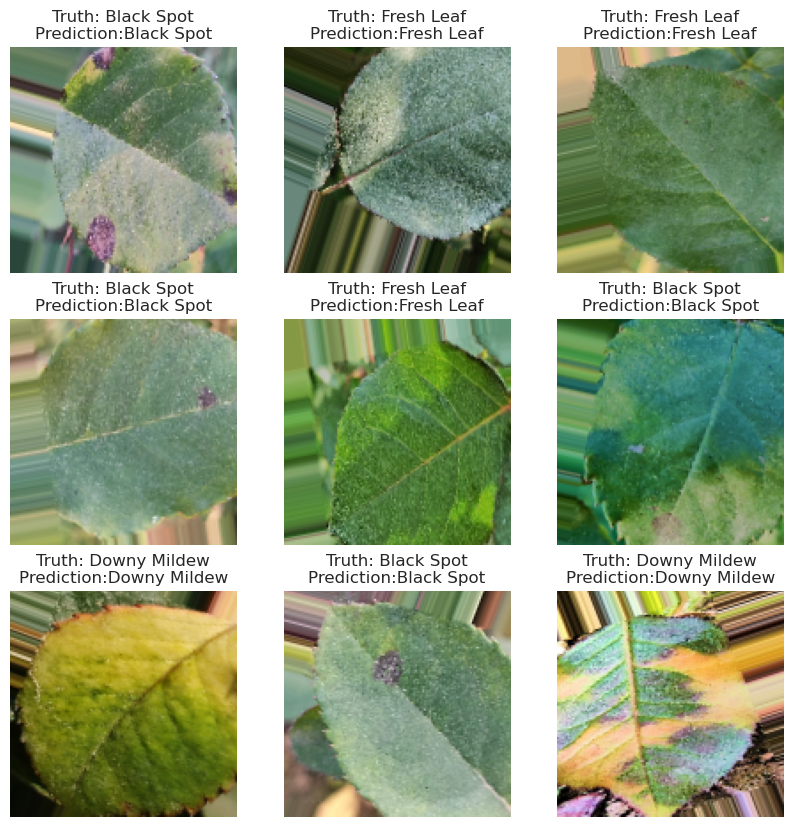

In [24]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict =model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label =coffee_classes[np.argmax(score)]
    plt.title(f'Truth: {coffee_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [25]:
model.save('MobileNetV2-baseline.h5')

# Initialize a new W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='Rose', 
                 config=CONFIG,
                 group='MobileNetV2', 
                 job_type='save') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Save model as Model Artifact
artifact = wandb.Artifact(name='MobileNetV2', type='model')
artifact.add_file('MobileNetV2-baseline.h5')
run.log_artifact(artifact)

# Finish W&B run
run.finish()

wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230606_043530-kdj8wjso
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run sage-leaf-7
wandb: ⭐️ View project at https://wandb.ai/sanjeevsharma22/Rose
wandb: 🚀 View run at https://wandb.ai/sanjeevsharma22/Rose/runs/kdj8wjso
wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run sage-leaf-7 at: https://wandb.ai/sanjeevsharma22/Rose/runs/kdj8wjso
wandb: Synced 5 W&B file(s), 0 media file(s), 1 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230606_043530-kdj8wjso/logs


<h2>Support by giving an upvote!!</h2>